In [1]:
from main_tp1_ex2 import *
import numpy as np
import math
import matplotlib.pyplot as plt
import time

# Exercise 1 - Dynamic programming

## Question 1

In [2]:
#"encoding" the discrete MDP model

#P[x,a,y] probability to move from state x to state y taking action a
P = np.zeros((3,3,3))
P[0] = np.array([[0.55,0.45,0], [0.3,0.7,0], [1,0,0]])
P[1] = np.array([[1,0,0], [0,0.4,0.6], [0,1,0]])
P[2] = np.array([[0,1,0], [0,0.6,0.4], [0,0,1]])

#R[x,a] reward for taking action a from state x
R = np.array([[0,0,0.05],[0,0,0],[0,1,0.9]])

In this discrete MDP model, the only non-zero rewards can be obtained taking action $a_2$ from state $s_2$ (0.9), action $a_1$ from $s_2$ (1) and action $a_2$ from $s_0$ (0.05). 

First of all, playing $a_2$ (resp. $a_2$) from $s_2$ (resp. $s_0$) leads with probability 1 to $s_2$ (resp. $s_0$). Hence, given the respective rewards, we clearly prefer to always play $a_2$ from $s_2$ than $a_2$ from $s_0$. 

Besides, playing $a_1$ from $s_2$ gives a higher immediate reward (1) than playing $a_2$ (0.9), but it leads to $s_1$ with probability 0.6, state where all rewards are zero. As the probability to go back to $s_2$ playing $a_1$ from $s_1$ is equal to 0.6, the expected gain in two iterations for the policy playing $a_1$ in $s_2$ and $a_1$ in $s_1$ is $0.6*0.6*1+0.4*0.6*1+0.4*0.4*1.95=0.912$, while, for the policy playing $a_2$ from $s_2$, it is $0.9+0.9*0.95 = 1.755$. 

Thus, we can guess that the best strategy is to maximize the probability to go to $s_2$ if we are in $s_1$ or in $s_0$, and to play $a_2$ in $s_2$.

This would lead to the optimal policy $\pi(s_0)=a_1, \pi(s_1)=a_1, \pi(s_2)=a_2$

## Question 2 - Value iteration

In [3]:
def BellmanOp(V,P,R,gamma):
    # returns a matrix M of size (number of states, number of actions)
    # where M[x,a] stores the expected gain if action a is taken from 
    # state x
    # V[x] is the estimated value of state x
    # P[x,a,y] is the probability to move from state x to state y 
    # taking action a
    # R[x,a] is the immediate reward for taking action a from state x
    # gamma is the discount factor

    return R + gamma * np.dot(P,V).reshape(R.shape)


def ValueFunction(pi,P,R,gamma):
    # return the value function of policy pi (policy evaluation)
    # as a vector of size Nstates
    N_states = pi.shape[0]
    #immediate reward in each state (given pi)
    im_reward = np.array([R[x,pi[x]] for x in range(N_states)])
    #probability transition matrix (given pi)
    proba_transition_given_pi = np.array([P[x,pi[x],:] for x in range(N_states)])

    #V solution of the equation : 
    #V =  im_reward + gamma * np.dot(proba_given_pi,V)
    res = np.linalg.solve(np.eye(N_states) - gamma * proba_transition_given_pi, im_reward)
    return res

def optimalPolicy_VI(V_init,P,R,gamma,q):
    # returns pi, V two vectors of size the number of states
    # where pi is the q-optimal policy and V is the associated value 
    # function
    # V_init is the initialization of the value function

    #V is a fixed point of the Bellman operator
    V_pis = [V_init]  #list of successive estimates of V

    eps = q*(1-gamma)/(2*gamma)
    deltaV = 1  #difference wrt. norm_infinity between two estimations of V

    time_pts = [time.time()]
    
    while (deltaV>eps):
        #applying the Bellman operator to last V found
        TV = BellmanOp(V_pis[-1],P,R,gamma)  
        
        #greedy policy (choosing action giving maximum gain)
        V_pis.append(np.max(TV,axis=1))    
        
        if len(V_pis)>1: #it is not the first iteration
            deltaV = np.max(np.abs(V_pis[-1] - V_pis[-2]))
        else:
            deltaV = 1 #to go to the next iteration
            
        time_pts.append(time.time())
    
    time_pts = np.array(time_pts) - time_pts[0]

    pi = np.argmax(TV, axis=1) #q-optimal policy
    V_pi = ValueFunction(pi,P,R,gamma) #value function associated
    
    print("Value iteration algorithm")
    print("\nV_init = "+str(V_init))
    print(str(q)+"-optimal policy : ", pi) 
    print("associated value function : ", V_pis[-1])
    errors = np.max(np.abs(np.array(V_pis)-V_pi), axis=1)
    plt.plot(list(range(len(errors))), errors, marker='x')
    plt.xlabel("value iteration (VI)")
    plt.ylabel("norm_infinity between q-optimal value function v* and iterates")
    plt.title("Value Iteration Algorithm starting from V_init="+str(V_init))
    plt.show()
    
    plt.plot(1000*time_pts, errors, marker='x')
    plt.xlabel("elapsed time (in ms)")
    plt.ylabel("norm_infinity between q-optimal value function v* and iterates")
    plt.title("Value Iteration Algorithm starting from V_init="+str(V_init))
    plt.show()

    return pi, V_pi

Value iteration algorithm

V_init = [1 0 0]
0.01-optimal policy :  [1 1 2]
associated value function :  [15.38629791 16.54352778 17.99514068]


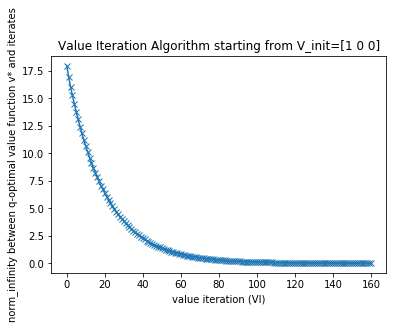

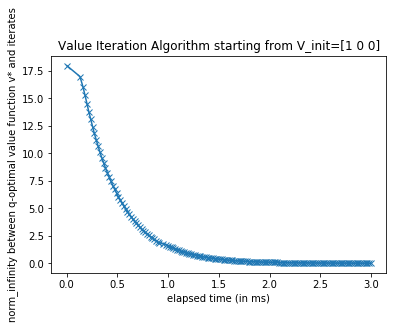

In [4]:
V_init = np.array([1,0,0])
pi, V = optimalPolicy_VI(V_init,P,R,0.95, 0.01)

## Question 3 - Policy iteration

In [5]:
def optimalPolicy_PI(pi_init,P,R,gamma):
    # returns pi, V two vectors of size the number of states
    # where pi is the exact optimal policy and V is the optimal value function
    # pi_init is the initial guess of the optimal policy

    pi = pi_init           #optimal policy
    V_pis = []             #list of successive estimates of V
    deltaV = [1]           #difference wrt. norm_infinity between two estimations of V

    time_pts = [time.time()]
    
    while (deltaV!=0):

        #policy evaluation :
        V_pis.append(ValueFunction(pi,P,R,gamma)) #value function associated with pi
        #policy improvement :
        TV = BellmanOp(V_pis[-1],P,R,gamma)  #applying the Bellman operator 
        pi = np.argmax(TV,axis=1)            #greedy policy gives the new policy

        if len(V_pis)>1: #it is not the first iteration
            deltaV = np.max(np.abs(V_pis[-1] - V_pis[-2]))
        else:
            deltaV = 1 #to go to the next iteration
            
        time_pts.append(time.time())
    
    time_pts = np.array(time_pts)[1:] - time_pts[0]

    #V_pi = ValueFunction(pi,P,R,gamma) #not useful as deltaV[-1]=0

    print("Policy iteration algorithm")
    print("\npi_init="+str(pi_init))
    print("exact optimal policy : ", pi, " \noptimal value function : ", V_pis[-1])
    errors = np.max(np.abs(np.array(V_pis) - V_pis[-1]),axis=1)
    plt.plot(list(range(len(errors))),errors,marker='x')
    plt.xlabel("policy iteration (PI)")
    plt.ylabel("norm_infinity between optimal value function v* and iterates")
    plt.title("Policy Iteration Algorithm starting from pi_init="+str(pi_init))
    plt.show()
    
    plt.plot(1000*time_pts,errors,marker='x')
    plt.xlabel("elapsed time (in ms)")
    plt.ylabel("norm_infinity between optimal value function v* and iterates")
    plt.title("Policy Iteration Algorithm starting from pi_init="+str(pi_init))
    plt.show()

    return pi, V_pis[-1]

Policy iteration algorithm

pi_init=[0 0 0]
exact optimal policy :  [1 1 2]  
optimal value function :  [15.39115723 16.5483871  18.        ]


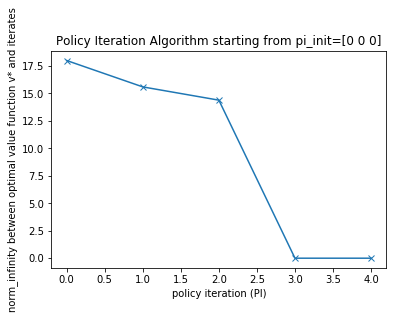

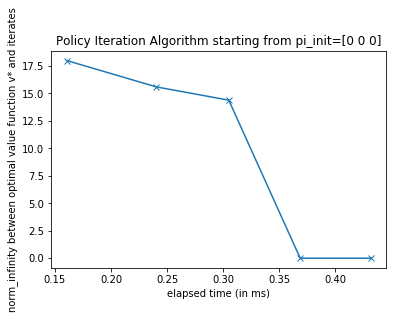

In [6]:
pi_init = np.array([0,0,0])
pi, V = optimalPolicy_PI(pi_init,P,R,0.95)

Value Iteration (VI) algorithm gives the 0.01-optimal policy in about 150 iterations (starting from $V_{init}=[1,0,0]$), while Policy Iteration  (PI) algorithm needs only 5 iterations to give the exact optimal policy (starting from $\pi_{init}=[0, 0, 0]$). But the iterations of PI are more expensive than those of VI. 

All in all, for this MDP, PI gives the exact optimal policy in less time than VI which gives an approximate one. This is probably because the number of states and actions is really small in this MDP that the cost of the policy evaluation of PI is not too big.

For a larger space of states/actions, the iterations of PI will be more expensive and we may prefer having an eps-optimal policy with VI in less time than an exact optimal policy with PI.

# Exercise 2 - Reinforcement Learning

## Question 4 - Policy evaluation

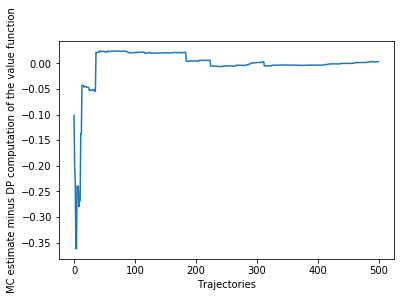

In [2]:
# here the v-function and q-function to be used for question 4
v_q4 = [0.87691855, 0.92820033, 0.98817903, 0.00000000, 0.67106071, -0.99447514, 0.00000000, -0.82847001, -0.87691855,
        -0.93358351, -0.99447514]

env = GridWorld1

def estimate_mu0(n=100):
    #estimate mu0 the starting state distribution
    #n is the number of environment reset 
    mu0 = np.zeros(env.n_states) #muo[x] : probability to start in state x
    for k in range(n):
        starting_state = env.reset()
        mu0[starting_state] +=1
    mu0 /= np.sum(mu0)
    return mu0

def action_policy_right_up(x):
    #returns the action given by the deterministic policy :
    #'right' when available from the state x,otherwise 'up'
    if 0 in env.state_actions[x]: #action 0 is 'right'
        return 0
    return 3 #action 3 is 'up'

#action taken in each state for this determistic policy
policy_right_up = [action_policy_right_up(x) for x in range(env.n_states)]


def estimate_V_MC(n=100,Tmax=100,gamma=0.95):
    #returns a matrix Vt of size (n,env.n_states)
    #where Vt[k,:] is the estimator of the value function at the end of 
    #trajectory k for policy_right_up
    #a trajectory is of maximal length Tmax, gamma is the discount factor

    Vt = np.zeros((n, env.n_states)) 
    #Vt[k,s] value function for state s at the end of trajectory k
    Nt = np.zeros((n,env.n_states)) 
    #N[k,s] number of trajectory beginning in s among first k trajectories

    k = 0 #number of trajectories done

    while k < n:

        # initial state
        init_state = env.reset()
        state = init_state #current state

        # simulating a trajectory
        t = 0
        term = False
        cumul_reward = 0 #cumulated reward for trajectory k
        while (t<Tmax) or (not(term)):
            action = policy_right_up[state]
            nexts, reward, term = env.step(state, action)
            cumul_reward += math.pow(gamma,t)*reward
            state = nexts
            t += 1

        # updating Vt[k,:] and Nt[k,:]
        if k == 0: #first trajectory
            Vt[0, init_state] = cumul_reward
            Nt[0, init_state] = 1
        else:
            Vt[k, :] = Vt[k - 1, :]
            Nt[k, :] = Nt[k - 1, :]
            Vt[k, init_state] += cumul_reward #trajectory began in init_state
            Nt[k, init_state] += 1

        k += 1

    for k in range(n):
        for s in range(env.n_states):
            if Nt[k,s]!=0:
                Vt[k,s] = Vt[k,s]/Nt[k,s]
    return Vt

mu0 = estimate_mu0(n = 100)
Vt = estimate_V_MC(n=500,Tmax=100,gamma=0.95) #of size (n,n_states)
J = Vt.dot(mu0) #(n,n_states) * (n,states,) = (n,)
J_pi = np.array(v_q4).dot(mu0)
plt.plot(J-J_pi)
plt.xlabel("Trajectories")
plt.ylabel("MC estimate minus DP computation of the value function")
plt.show()

I plotted the difference between the computation by DP of the  weighted  average (by the starting state distribution) of the value function associated to the deterministic policy "right-up" and its Monte-Carlo estimates at the end of each trajectory (N=500 trajectories of length < Tmax=100). The starting state distribution $\mu_0$ was estimated resetting the environment a hundred times.

We observe the convergence of the Monte-Carlo estimator towards the weighted average of the value function computed with DP.

## Question 5 - Policy optimization

In [23]:
v_opt = [0.87691855, 0.92820033, 0.98817903, 0.00000000, 0.82369294, 0.92820033, 0.00000000, 0.77818504, 0.82369294,
         0.87691855, 0.82847001]

def eps_greedy_policy(state,Q,eps):
    #returns the action given by the eps-greedy policy in the state
    #and the associated value of theQ state action value fonction
    if eps==0: #greedy policy
        u = 0
    else:
        u = np.random.uniform(0,1,1)
    set_actions = env.state_actions[state]
    if u<1-eps:
        best_action = set_actions[0]
        Q_best_action = Q[state,best_action]
        for action in set_actions:
            if Q[state,action]>Q_best_action:
                best_action = action
                Q_best_action = Q[state,best_action]
        return best_action, Q_best_action
    else:
        action = np.random.choice(set_actions)
        return action, Q[state,action]

def Q_Learning(n=100,Tmax=100,gamma=0.95,eps=0.1):
    # returns Qt, R
    # where Qt[k,s,a] is the Q-value function for state s and action a 
    # estimated at the end of the k-th episode
    # and R[t] cumulated reward for the k-th episode
    # n is the number of episodes, Tmax the maximal length of an episode
    # action are taken following an eps-greedy policy wrt. to Q
    # gamma is the discount factor

    n_actions = len(env.action_names)
    Qt = np.zeros((n, env.n_states, n_actions)) #estimates of Q-value function
    Qt[0,:,:] = np.random.rand(env.n_states, n_actions) 
    R = np.zeros(n)  #cumulated reward over the episodes
    
    #N[s,a] number fo visits of the state-action (s,a) until current trajectory
    N = np.zeros((env.n_states, n_actions)) 

    for k in range(n): #k index of the episode

        state = env.reset()

        t = 0
        term = False
        while (t < Tmax) and (not (term)):

            #taking action following eps_greedy_policy
            action = eps_greedy_policy(state,Qt[k,:,:],eps)[0]
            nexts, reward, term = env.step(state, action)

            #updating Q
            alpha = 1/(N[state,action]+1)
            Qt[k, state, action] = (1-alpha)*Qt[k, state, action]
            Qt[k, state, action] += alpha*(reward+gamma*np.max(Qt[k, nexts, env.state_actions[nexts]]))

            #updating the number of visits
            N[state, action] += 1

            #updating the reward
            R[k] += math.pow(gamma, t) * reward

            state = nexts
            t += 1

        if k<n-1:
            Qt[k+1, :, :] = Qt[k, :, :]

    return Qt, R

Qt, R = Q_Learning(n=1000,Tmax=100,gamma=0.95,eps=0.3)

[[ 1.01573467  0.75802993  0.18390561  0.65645161]
 [ 1.01447489  0.48799451  0.99180459  0.09693232]
 [ 1.0151063   0.95057662  1.01511267  0.80801842]
 [ 0.          0.5188539   0.64925587  0.24104893]
 [ 0.78949538  0.65433973  0.3149501   0.89868039]
 [-0.86975779  0.8003991   0.71269717  0.98199696]
 [ 0.          0.30262119  0.92525892  0.3841134 ]
 [ 0.66168375  0.57733087  0.26955303  0.73682866]
 [ 0.84641842  0.75869767  0.60428486  0.5084484 ]
 [ 0.69386712  0.38961003  0.68886799  0.92840812]
 [ 0.01657247  0.60919757  0.81641998 -0.80396783]]


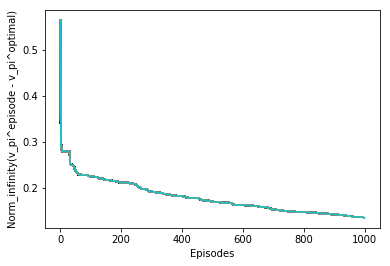

[0.87691855, 0.92820033, 0.98817903, 0.0, 0.82369294, 0.92820033, 0.0, 0.77818504, 0.82369294, 0.87691855, 0.82847001]
[0.636015246991051, 0.639880720509352, 0.7639738149752103, 0.5648214787168299, 0.6190330496337905, 0.7436026827093241, 0.27963357861940963, 0.5545261790604752, 0.5370305547334743, 0.8273433440957272, 0.9452936625066999]


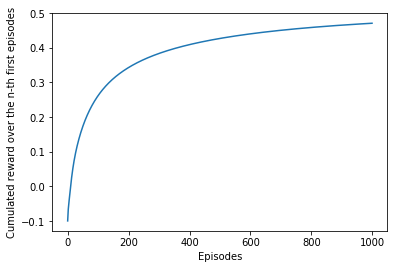

In [21]:
#plotting the norm_inf of the diff between the value function of the policy
#at the end of the episodes and the one of the optimal policy

value_policies = []
for k in range(Qt.shape[0]):
    value_policy = [eps_greedy_policy(s,Qt[k,:,:],0)[1] for s in range(env.n_states)]
    value_policies.append(value_policy)
    plt.plot(np.max(np.abs(np.array(value_policies) - v_opt),axis=1))
plt.xlabel("Episodes")
plt.ylabel("Norm_infinity(v_pi^episode - v_pi^optimal)")
plt.show()

print(v_opt)
print(value_policies[1])

#plotting the cumulated reward over the n-th first episodes
for n in range(1,R.shape[0]):
    R[n]+=R[n-1]
R/=np.arange(1,R.shape[0]+1)

plt.plot(R)
plt.xlabel("Episodes")
plt.ylabel("Cumulated reward over the n-th first episodes")
plt.show()

I used an eps=0.3-greedy exploration policy, and chose a learning rate $\alpha_i(x,a) = 1/(N_i(x,a)+1)$ with $N_i(x,a)$ the number of visits of state-action (x,a) until episode i (the Riemann series $\sum_{k \geq 1} 1/k$ diverges while $\sum_{k \geq 1} 1/k^2$ converges).

We observe the convergence towards $v^*$ (in norm infinity) of the value functions associated with the greedy policies with respect to the successive estimates of the best Q. Which shows the convergence of the Q-Learning algorithm.

For such value of epsilon, the sum of the cumulated rewards from the beginning (first episode) converges to 0.6.

## Question 6

The optimal policy of an MDP is optimal for all states (cf.course). In any state $x$ reached at a certain time of the trajectory, it chooses the action $a$ maximizing the immediate reward plus the future gain given the probability of transitions, which only depend on $x$ and $a$, not on the past states or actions. The optimal policy of an MDP is not affected by the change of the initial distribution.